# EEG Classification with 1D Convolutional Network (Pytorch)

**Data Preprocessing (Ver. 1)**

Raw data is normalized and highpass filtered at 1 Hz and segmented.

**Data**

*EEGBCI Data Description*: https://physionet.org/content/eegmmidb/1.0.0/#files-panel

*Paper*: https://pubmed.ncbi.nlm.nih.gov/15188875/

*EEG electrodes*: https://physionet.org/content/eegmmidb/1.0.0/64_channel_sharbrough.pdf

**Reference**

*Model architecture*: https://github.com/joshualin24/EEG_demo/blob/main/EEG_supervised_CNN.ipynb



## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-da4847fb-07d8-7f48-823e-cb1e1689713f)


## Import Libraries

In [ ]:
!pip install torch-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import Sequential, Conv1d, Linear, Dropout, AvgPool1d
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary

import time
import os
import zipfile
from copy import deepcopy

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(0)

## Custom Datasets

In [4]:
class EEGWindowDataset(Dataset):
    def __init__(self, csv_file, eeg_dir, transform=None):
        """
        Args:
            csv_file (string): path to the label csv
            eeg_dir (string): path to the dir containing all EEG windows (.npy files)
            transform (callable, optional): transform to apply
        """
        self.labels_df = pd.read_csv(csv_file)
        self.eeg_dir = eeg_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # subject id
        subject_id = self.labels_df.iloc[idx, 2]
        # read numpy data
        data = np.load(os.path.join(self.eeg_dir, self.labels_df.iloc[idx, 0])).astype('float')
        assert data.shape[0] == 64
        # apply transform (optional)
        if self.transform is not None:
            data = self.transform(data)
        # true label
        label = int(self.labels_df.iloc[idx, 1])

        return data, label, int(subject_id)

## Create Dataset and Dataloaders

In [5]:
data_train = EEGWindowDataset(csv_file='EEGBCI_data/WS640_c10_train_labels.csv',
                              eeg_dir='EEGBCI_data/WS640_v1_c10/train',
                              transform=None)

data_val = EEGWindowDataset(csv_file='EEGBCI_data/WS640_c10_val_labels.csv',
                            eeg_dir='EEGBCI_data/WS640_v1_c10/val',
                            transform=None)

data_test = EEGWindowDataset(csv_file='EEGBCI_data/WS640_c10_test_labels.csv',
                             eeg_dir='EEGBCI_data/WS640_v1_c10/test',
                             transform=None)

## Training and Evaluation Function

In [6]:
def train_model(model, model_name, num_epochs, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10):
    """
    Train the model
    Args:
        model: Pytorch neural model
        model_name: (str) unique name of the model
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
        scheduler: the learning rate decay scheduler
        print_every: print the information every X epochs
        early_stop_epochs: early stopping if the model doesn't improve after X epochs
    """

    # cache the best model
    best_model_weights = deepcopy(model.state_dict())
    # best train acc
    best_train_acc = 0.0
    # best valid acc
    best_valid_acc = 0.0
    # best epoch
    best_epoch = -1    

    # intiate dict to records the history of loss and acc
    history_dic = dict()
    history_dic['train_loss'] = []
    history_dic['train_acc'] = []
    history_dic['valid_loss'] = []
    history_dic['valid_acc'] = []
    history_dic['lr'] = []

    for epoch in range(num_epochs):
        # time of start
        epoch_start_time = time.time()

        """ Train """
        model.train()

        epoch_train_cum_loss = 0.0
        epoch_train_cum_corrects = 0
        
        for data, labels, _ in train_loader:  # data, label, subject_id
            data = data.float().to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            
            pred_logits = model(data)
            loss = criterion(pred_logits, labels)

            _, pred_classes = torch.max(pred_logits.detach(), dim=1)
            pred_classes = pred_classes.long()

            epoch_train_cum_loss += loss.item() * data.size(0)
            epoch_train_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

            loss.backward()
            optimizer.step()
            
        """ Eval """
        model.eval()

        epoch_valid_cum_loss = 0.0
        epoch_valid_cum_corrects = 0

        for data, labels, _ in val_loader:
            data = data.float().to(device)
            labels = labels.long().to(device)

            with torch.no_grad():
                pred_logits = model(data)
                _, pred_classes = torch.max(pred_logits.detach(), dim=1)
                loss = criterion(pred_logits, labels)

                epoch_valid_cum_loss += loss.item() * data.size(0)
                epoch_valid_cum_corrects += torch.sum(pred_classes==labels.data).detach().to('cpu').item()

        ## Calculate metrics
        train_loss = epoch_train_cum_loss / len(data_train)
        train_acc = epoch_train_cum_corrects / len(data_train)
        valid_loss = epoch_valid_cum_loss / len(data_val)
        valid_acc = epoch_valid_cum_corrects / len(data_val)

        # update history_dic
        history_dic['train_loss'].append(train_loss)
        history_dic['train_acc'].append(train_acc)
        history_dic['valid_loss'].append(valid_loss)
        history_dic['valid_acc'].append(valid_acc)
        history_dic['lr'].append(scheduler.get_last_lr()[0])

        # check if is the best acc ever
        if valid_acc > best_valid_acc:
            best_train_acc = train_acc
            best_valid_acc = valid_acc
            best_epoch = epoch + 1
            # update the best model weights
            best_model_weights = deepcopy(model.state_dict())
            # save the best model weights to Google drive
            torch.save(model.state_dict(), os.path.join('results/conv1d', model_name + "_cache.pth"))

        epoch_end_time = time.time()
        epoch_time_used = epoch_end_time - epoch_start_time
        # convert epoch_time_used into mm:ss
        mm = epoch_time_used // 60
        ss = epoch_time_used % 60

        ## Print metrics
        if (epoch+1) % print_every == 0:

            # if is best valid acc
            if epoch == (best_epoch - 1):
                print("Epoch {}/{}\tTrain loss: {:.4f}  Train acc: {:.4f}  Valid loss: {:.4f}  Valid acc: {:.4f}  Time: {:.0f}m {:.0f}s\t<--".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            # not a better model
            else:
                print("Epoch {}/{}\tTrain loss: {:.4f}  Train acc: {:.4f}  Valid loss: {:.4f}  Valid acc: {:.4f}  Time: {:.0f}m {:.0f}s".format(
                    epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc, mm, ss))
            
        ## Early stopping
        if (epoch+1) - best_epoch >= early_stop_epochs:
            print("Early stopping... (Model did not improve after {} epochs)".format(early_stop_epochs))
            break
        
        scheduler.step()
    
    # load the best weights into the model
    model.load_state_dict(best_model_weights)
    # print the best epoch
    print("Best epoch = {}, with training accuracy = {:.4f} and validation accuracy = {:.4f}".format(best_epoch, best_train_acc, best_valid_acc))
    print("===============================\n")
    
    # Save the best weights
    torch.save(model.state_dict(), os.path.join('results/conv1d', model_name + '.pth'))

    # Convert history to dataframe
    history_df = pd.DataFrame(history_dic)

    # Save the history
    history_df.to_csv(os.path.join('results/conv1d', model_name + '_history.csv'), index=False)
    
    """ Test Data """
    model.eval()

    # empty lists for results
    y_true = []
    y_pred = []
    y_subject = []

    for data, labels, subject in test_loader:
        data = data.float().to(device)
        labels = labels.long().to(device)

        with torch.no_grad():
            pred_logits = model(data)
            _, pred_classes = torch.max(pred_logits.detach(), dim=1)

            y_true += torch.squeeze(labels.cpu()).tolist()
            y_pred += torch.squeeze(pred_classes).tolist()
            y_subject += torch.squeeze(subject.cpu()).tolist()
    
    # create a DataFrame with columns 'subject', 'class', 'pred'
    predict_df = pd.DataFrame(data={'subject': y_subject, 'class': y_true, 'pred': y_pred})
    
    predict_df.to_csv(os.path.join('results/conv1d', model_name + '_predictions.csv'), index=False)
    
    # Evaluation metrics
    class_labels = ['rest/eye-open',
                    'rest/eye-closed',
                    'movement/left/fist',
                    'movement/right/fist',
                    'imagery/left/fist',
                    'imagery/right/fist',
                    'movement/both/fist',
                    'movement/both/feet',
                    'imagery/both/fist',
                    'imagery/both/feet']

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    # accuracy of each class
    for c in range(8):
        print("Class {}: accuracy = {:.4f} ({})".format(c, cm[c,c]/sum(cm[c,:]), class_labels[c]))
    print("================")

    # accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Total Accuracy = {:.4f}".format(acc))
    # precision
    precision = precision_score(y_true, y_pred, average='macro')
    print("Precision = {:.4f}".format(precision))
    # recall
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall = {:.4f}".format(recall))
    # f1 score
    F1 = f1_score(y_true, y_pred, average='macro')
    print("F1 score = {:.4f}".format(F1))
    # confusion matrix
    sns.set(font_scale=1.6)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm_df, annot=True, fmt=".1%", cmap="YlGnBu", cbar=False, annot_kws={"size": 16})
    plt.show()
    
    # return the best model
    return model, history_dic

## Train model

**Model: eeg_conv1d_041022_night**


**Hyperparameters**
Batch_size = 64
LR = 0.0001
STEP_SIZE = 200
GAMMA = 0.9
MAX_EPOCH = 200
DROPOUT = 0.1


**Dataloaders**
Number of training data: 17716 (277 batches)
Number of validation data: 2215 (35 batches)
Number of test data: 2215 (35 batches)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 160]             34,848
├─Conv1d: 1-2                            [-1, 16, 40]              8,720
├─Conv1d: 1-3                            [-1, 16, 10]              4,368
├─Dropout: 1-4                           [-1, 160]                 --
├─Linear: 1-5                            [-1, 10]                  1,610
Total params: 49,546
Trainable params: 49,546
Non-trainable params: 0
Total mult-adds (M): 5.96
Input size (MB): 0.16
Forward/backward pass size (MB): 0.05
Params size (MB): 0.19
Estimated Total Size (MB): 0.39


Epoch 1/200	Train loss: 2.2883  Train acc: 0.1145  Valid 

Epoch 66/200	Train loss: 1.3234  Train acc: 0.5275  Valid loss: 1.7587  Valid acc: 0.3788  Time: 0m 16s
Epoch 67/200	Train loss: 1.3170  Train acc: 0.5272  Valid loss: 1.7540  Valid acc: 0.3783  Time: 0m 16s
Epoch 68/200	Train loss: 1.3149  Train acc: 0.5334  Valid loss: 1.7566  Valid acc: 0.3756  Time: 0m 16s
Epoch 69/200	Train loss: 1.3065  Train acc: 0.5340  Valid loss: 1.7567  Valid acc: 0.3747  Time: 0m 17s
Epoch 70/200	Train loss: 1.3006  Train acc: 0.5379  Valid loss: 1.7605  Valid acc: 0.3788  Time: 0m 17s
Epoch 71/200	Train loss: 1.2950  Train acc: 0.5395  Valid loss: 1.7581  Valid acc: 0.3801  Time: 0m 17s
Epoch 72/200	Train loss: 1.2883  Train acc: 0.5414  Valid loss: 1.7574  Valid acc: 0.3801  Time: 0m 17s
Epoch 73/200	Train loss: 1.2815  Train acc: 0.5467  Valid loss: 1.7593  Valid acc: 0.3815  Time: 0m 18s	<--
Epoch 74/200	Train loss: 1.2766  Train acc: 0.5445  Valid loss: 1.7623  Valid acc: 0.3856  Time: 0m 17s	<--
Epoch 75/200	Train loss: 1.2644  Train acc: 0.5538  Vali

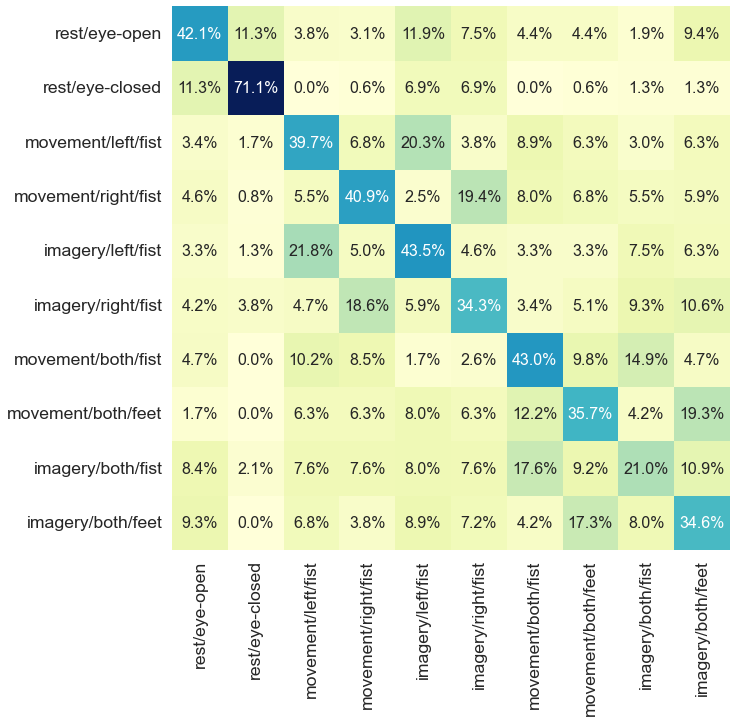

In [15]:
model_name = 'eeg_conv1d_041022_night'

class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.5):
        super(CNN, self).__init__()

        self.conv1 = Conv1d(in_channels=64, out_channels=32, kernel_size=17, stride=4, padding=8) # (32, 160)
        self.conv2 = Conv1d(in_channels=32, out_channels=16, kernel_size=17, stride=4, padding=8) # (16, 40)
        self.conv3 = Conv1d(in_channels=16, out_channels=16, kernel_size=17, stride=4, padding=8) # (16, 10)
        self.dropout = Dropout(dropout_p)
        self.out = Linear(160, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        output = self.out(x)
        return output
    
    
## Hyperparameter
BATCH_SIZE = 64
DROPOUT = 0.1
LR = 1e-4
STEP_SIZE = 200
GAMMA = 0.9
MAX_EPOCH = 200

print("**Model: {}**".format(model_name))
print("\n")

print("**Hyperparameters**")
print("Batch_size = {}".format(BATCH_SIZE))
print("LR = {}".format(LR))
print("STEP_SIZE = {}".format(STEP_SIZE))
print("GAMMA = {}".format(GAMMA))
print("MAX_EPOCH = {}".format(MAX_EPOCH))
print("DROPOUT = {}".format(DROPOUT))
print("\n")


## Dataloader
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE)
val_loader = DataLoader(data_val, batch_size=BATCH_SIZE)
test_loader = DataLoader(data_test, batch_size=BATCH_SIZE)
print("**Dataloaders**")
print("Number of training data: {} ({} batches)".format(len(data_train), len(train_loader)))
print("Number of validation data: {} ({} batches)".format(len(data_val), len(val_loader)))
print("Number of test data: {} ({} batches)".format(len(data_test), len(test_loader)))
print("\n")


## Create model
model = CNN(num_classes=10, dropout_p=DROPOUT)
summary(model, (64, 640))
print("\n")


# move to gpu
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
## train and return the best model
model, history_dic = train_model(model, model_name, MAX_EPOCH, criterion, optimizer, scheduler, print_every=1, early_stop_epochs=10)